# 薈萃式學習 Ensemble Learning

#### Prof. Ching-Shih Tsou (Ph.D.) (鄒慶士教授, Ph.D.) at the Institute of Information and Decision Sciences/Center for Applications of Data Science (CADS), National Taipei University of Business (國立臺北商業大學資訊與決策科學研究所教授兼資料科學應用研究中心主任); the Chinese Academy of R Software (CARS) (中華R軟體學會創會理事長) and the Data Science and Business Applications Association of Taiwan (DSBA) (臺灣資料科學與商業應用協會創會理事長)

## 大綱

> 資料載入與前處理

> 基於超參數最佳化的Gradient Boosting的銷售預測模型

> 拔靴集成法Bagging與隨機森林Random Forest的集成模型

> 類神經網路與深度學習的學習方式


## 資料載入與前處理 Loading and preprocessing the data

- scikit-learn除了許多機器學習演算法外，還有許多前處理、模型調校與評估等函數

- 商品銷售預測幾乎是每個營運部門的必備資料應用項目，無論是大型促銷活動還是單品銷售都是如此。
在此處使用的資料集就是針對某單品做的訂單量進行預測應用。

In [1]:
import sklearn
sklearn.__file__

'/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/__init__.py'

In [2]:
sklearn.__version__

'0.19.1'

In [3]:
## from sklearn import datasets
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor  # 集成方法迴歸套件：梯度效能提升迴歸樹
from sklearn.model_selection import GridSearchCV  # 載入交叉驗證套件：網格參數最佳化交叉驗證(update skleran to 0.19.1, scipy and restart Python!)
import matplotlib.pyplot as plt  # 載入繪圖套件

raw_data = pd.read_table('products_sales.txt', delimiter=',')

In [4]:
raw_data.head()

,limit_infor,campaign_type,campaign_level,product_level,resource_amount,email_rate,price,discount_rate,hour_resouces,campaign_fee,orders
0,0,6,0,1,1,0.08,140.0,0.83,93,888,1981
1,0,0,0,1,1,0.10,144.0,0.75,150,836,986
2,0,1,1,1,1,0.12,149.0,0.84,86,1330,1416
3,0,3,1,2,1,0.12,141.0,0.82,95,2273,2368
4,0,0,0,1,1,0.10,146.0,0.59,73,1456,1529


- 資料審查和校驗
- 資料概覽，注意price有遺缺值，campaign_fee有異常極大值！

In [5]:
print ('{:*^60}'.format('Data overview:'))
print (raw_data.tail(2))  # 印出原始數據後2條
print ('{:*^60}'.format('Data dtypes:'))
print (raw_data.dtypes)  # 印出數據類型
print ('{:*^60}'.format('Data DESC:'))
print (raw_data.describe().round(1).T)  # 印出原始數據基本描述性信息

***********************Data overview:***********************
     limit_infor  campaign_type  campaign_level  product_level  \
729            0              6               0              1   
730            0              6               0              1   

     resource_amount  email_rate  price  discount_rate  hour_resouces  \
729                8         0.8  150.0           0.87            987   
730                9         0.8  149.0           0.84           1448   

     campaign_fee  orders  
729          2298    3285  
730          3392    4840  
************************Data dtypes:************************
limit_infor          int64
campaign_type        int64
campaign_level       int64
product_level        int64
resource_amount      int64
email_rate         float64
price              float64
discount_rate      float64
hour_resouces        int64
campaign_fee         int64
orders               int64
dtype: object
*************************Data DESC:*************************
   

- limit_info: 是否限購 [0  1 10??]
- campaign_type: 促銷活動類型 [0 1 2 3 4 5 6]
- campaign_level: 促銷活動重要性 [0 1]
- product_level: 產品重要度 [1 2 3]
- resource_amount: 促銷資源數量
- email_rate: 電郵促銷含該產品的比例
- price: 單價
- discount_rate: 折扣率
- hour_resources: 促銷展示時數
- campaign_fee: 產品促銷綜合費用
- orders: 每次活動的訂單量

- 查看值域分布與次數分配表

In [6]:
col_names = ['limit_infor', 'campaign_type', 'campaign_level', 'product_level']  # 定義要查看的列column
for col_name in col_names:  # 使用迴圈讀取每個列column
    unque_value = np.sort(raw_data[col_name].unique())  # 獲得列的唯一值
    print ('{:*^50}'.format('{1} unique values:{0}').format(unque_value, col_name))  # 打出

**************limit_infor unique values:[ 0  1 10]***************
**************campaign_type unique values:[0 1 2 3 4 5 6]***************
**************campaign_level unique values:[0 1]***************
**************product_level unique values:[1 2 3]***************


In [7]:
for col_name in col_names:  # 使用迴圈讀取每個列column
    vc = raw_data[col_name].value_counts()  # 獲得列column的次數分配表
    print ('\n{:*^50}'.format('freq table of {1} :\n{0}').format(vc, col_name))  # 印出


*************freq table of limit_infor :
0     709
1      21
10      1
Name: limit_infor, dtype: int64**************

*************freq table of campaign_type :
6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: campaign_type, dtype: int64**************

*************freq table of campaign_level :
1    500
0    231
Name: campaign_level, dtype: int64**************

*************freq table of product_level :
1    463
2    247
3     21
Name: product_level, dtype: int64**************


- 遺缺值審查，只有price有遺缺值
- 有兩筆觀測值具遺缺值

In [8]:
na_cols = raw_data.isnull().any(axis=0)  # 查看每一列column是否具有遺缺值
print ('{:*^60}'.format('NA Cols:'))
print (na_cols)  # 查看具有缺失值的列column
na_lines = raw_data.isnull().any(axis=1)  # 查看每一行row是否具有遺缺值
print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有遺缺值的行row總記錄數

**************************NA Cols:**************************
limit_infor        False
campaign_type      False
campaign_level     False
product_level      False
resource_amount    False
email_rate         False
price               True
discount_rate      False
hour_resouces      False
campaign_fee       False
orders             False
dtype: bool
Total number of NA lines is: 2


- 相關性分析

In [9]:
print ('{:*^60}'.format('Correlation Analyze:'))
short_name = ['li', 'ct', 'cl', 'pl', 'ra', 'er', 'price', 'dr', 'hr', 'cf', 'orders']
long_name = raw_data.columns
name_dict = dict(zip(long_name, short_name))
print (raw_data.corr().round(2).rename(index=name_dict, columns=name_dict))  # 輸出所有輸入特徵變量以及預測變量的相關性矩陣
print (name_dict)

********************Correlation Analyze:********************
          li    ct    cl    pl    ra    er  price    dr    hr    cf  orders
li      1.00 -0.03 -0.08 -0.04  0.05  0.04  -0.02  0.00  0.01 -0.04   -0.02
ct     -0.03  1.00  0.04  0.03  0.01 -0.01  -0.05 -0.01  0.06  0.06    0.06
cl     -0.08  0.04  1.00  0.06  0.05  0.05   0.02  0.02 -0.52  0.26    0.05
pl     -0.04  0.03  0.06  1.00 -0.12 -0.12   0.59 -0.04 -0.25 -0.23   -0.30
ra      0.05  0.01  0.05 -0.12  1.00  0.98   0.13  0.15  0.54  0.46    0.62
er      0.04 -0.01  0.05 -0.12  0.98  1.00   0.14  0.18  0.54  0.47    0.63
price  -0.02 -0.05  0.02  0.59  0.13  0.14   1.00  0.25 -0.08 -0.11   -0.10
dr      0.00 -0.01  0.02 -0.04  0.15  0.18   0.25  1.00  0.17  0.19    0.23
hr      0.01  0.06 -0.52 -0.25  0.54  0.54  -0.08  0.17  1.00  0.32    0.66
cf     -0.04  0.06  0.26 -0.23  0.46  0.47  -0.11  0.19  0.32  1.00    0.76
orders -0.02  0.06  0.05 -0.30  0.62  0.63  -0.10  0.23  0.66  0.76    1.00
{'limit_infor': 'li', 'camp

- 數據預處理，遺缺值替換為平均值後儲存為sales_data (fill.na方法)
- 只保留促銷值為0和1的記錄(促銷值10的紀錄只有一筆)
- 異常值處理，將異常極大值替換為平均值 (replace方法)
- 印出處理完成數據基本描述性信息 (describe + rename方法)

In [10]:
sales_data = raw_data.fillna(raw_data['price'].mean())  # 遺缺值替換為平均值
# sales_data = raw_data.drop('email_rate',axis=1) # 或移除遺缺值
sales_data = sales_data[sales_data['limit_infor'].isin((0, 1))]  # 只保留促銷值為0和1的記錄
sales_data['campaign_fee'] = sales_data['campaign_fee'].replace(33380, sales_data['campaign_fee'].mean())  # 將異常極大值替換為平均值
print ('{:*^60}'.format('transformed data:'))
print (sales_data.describe().round(2).T.rename(index=name_dict))  # 印出處理完成數據基本描述性信息

*********************transformed data:**********************
        count     mean      std     min      25%      50%      75%      max
li      730.0     0.03     0.17    0.00     0.00     0.00     0.00     1.00
ct      730.0     3.00     2.01    0.00     1.00     3.00     5.00     6.00
cl      730.0     0.68     0.47    0.00     0.00     1.00     1.00     1.00
pl      730.0     1.40     0.55    1.00     1.00     1.00     2.00     3.00
ra      730.0     4.95     1.84    1.00     3.00     5.00     7.00     9.00
er      730.0     0.47     0.16    0.08     0.34     0.48     0.61     0.84
price   730.0   162.82    14.26  100.00   152.00   163.00   173.00   197.00
dr      730.0     0.81     0.08    0.49     0.77     0.82     0.87     0.98
hr      730.0   848.51   687.03    2.00   315.25   717.00  1096.50  3410.00
cf      730.0  3655.61  1561.27   20.00  2495.00  3660.00  4783.25  6946.00
orders  730.0  4531.27  1933.85   22.00  3196.50  4566.00  6021.25  8714.00


- 分割資料集sales_data為屬性矩陣X和數值變數向量y

In [11]:
X = sales_data.iloc[:, :-1]  # 分割X(從頭取到倒數第一column)
y = sales_data.iloc[:, -1]  # 分割y(取倒數第一column)

- 切割資料集為70%訓練集與30%測試集 Splitting data into 70% training and 30% test data:

In [12]:
from sklearn.model_selection import train_test_split # cross_validation has been changed to model_selection

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

- 屬性標準化Standardizing the features:

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train) # 依X_train估計mu與sigma

#sc.mean_
#sc.scale_

X_train_std = sc.transform(X_train) # 真正作轉換
X_test_std = sc.transform(X_test)

In [14]:
print (sc)
# print (help(sc))

StandardScaler(copy=True, with_mean=True, with_std=True)


## 基於超參數最佳化的Gradient Boosting的銷售預測模型

- import -> instantiate -> fit and transform

In [15]:
model_gbr = GradientBoostingRegressor()  # 建立GradientBoostingRegressor迴歸物件
parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'alpha': [0.1, 0.3, 0.6, 0.9]}  # 定義要優化的參數信息之字典
#alpha float, default=0.9. The alpha-quantile of the huber loss function and the quantile loss function. Only if loss='huber' or loss='quantile'. Values must be in the range (0.0, 1.0).
model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5)  # 建立交叉檢驗模型對象

- 衡量程式碼執行時間

In [16]:
import time
start = time.time()
"the code you want to test stays here"
model_gs.fit(X, y)  # 訓練交叉檢驗模型(所以丟全部樣本進去)
end = time.time()
print(end - start) # 37.64466881752014

58.12251806259155


In [17]:
print ('Best score is:', model_gs.best_score_)  # 獲得交叉檢驗模型得出的最佳得分
print ('Best parameter is:', model_gs.best_params_)  # 獲得交叉檢驗模型得出的最佳參數

Best score is: 0.9317656782417922
Best parameter is: {'alpha': 0.9, 'loss': 'huber', 'min_samples_leaf': 3}


In [18]:
type(model_gs)

sklearn.model_selection._search.GridSearchCV

In [19]:
dir(model_gs)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_is_fitted',
 '_estimator_type',
 '_get_param_iterator',
 '_get_param_names',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'fit_params',
 'get_params',
 'grid_scores_',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'return_train_scor

- 獲取最佳訓練模型

In [20]:
model_best = model_gs.best_estimator_  # 獲得交叉檢驗模型得出的最佳模型物件
model_best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

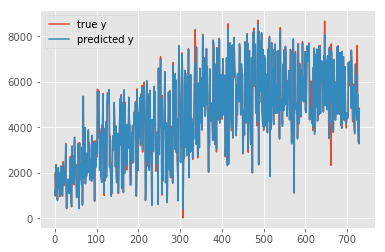

In [21]:
model_best.fit(X, y)  # 訓練最佳模型
plt.style.use("ggplot")  # 應用ggplot樣式
plt.figure()  # 建立畫布物件
plt.plot(np.arange(X.shape[0]), y, label='true y')  # 畫出原始變量的曲線
plt.plot(np.arange(X.shape[0]), model_best.predict(X), label='predicted y')  # 畫出預測變量的曲線
plt.legend(loc=0)  # 設置圖例位置
plt.show()  # 顯示圖形

- 新資料集預測

In [22]:
New_X = np.array([[1, 1, 0, 1, 15, 0.5, 177, 0.66, 101, 798]])  # 要預測的新數據記錄(10個變數)
print ('{:*^60}'.format('Predicted orders:'))
print (model_best.predict(New_X).round(0))  # 印出預測值

*********************Predicted orders:**********************
[779.]


## 拔靴集成法Bagging與隨機森林Random Forest的集成模型

> 模組載入

In [23]:
import numpy as np  # numpy庫
import pandas as pd  # pandas庫
from sklearn.feature_extraction import DictVectorizer  # 數值分類轉整數分類庫
from imblearn.over_sampling import SMOTE  # 過抽樣處理庫SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score  # 導入交叉檢驗算法
from sklearn.linear_model import LogisticRegression  # 導入邏輯回歸庫
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier  # 三種集成分類庫和投票方法庫：投票分類器、隨機森林分類器、拔靴集成分類器

> 數據審查和預處理函數

- 基本狀態查看函數`set_summary`

In [25]:
def set_summary(df):
    '''
    查看數據集後2條數據、數據類型、描述性統計
    :param df: 數據框
    :return: 無
    '''
    print ('{:*^60}'.format('Data overview:'))
    print (df.tail(2))  # 打印原始數據後2條
    print ('{:*^60}'.format('Data dtypes:'))
    print (df.dtypes)  # 打印數據類型
    print ('{:*^60}'.format('Data DESC:'))
    print (df.describe().round(2).T)  # 打印原始數據基本描述性信息

- 缺失值審查函數`na_summary`

In [26]:
def na_summary(df):
    '''
    查看數據集的缺失數據列、行記錄數
    :param df: 數據框
    :return: 無
    '''
    na_cols = df.isnull().any(axis=0)  # 查看每一列是否具有缺失值
    print ('{:*^60}'.format('NA Cols:'))
    print (na_cols)  # 查看具有缺失值的列
    na_lines = df.isnull().any(axis=1)  # 查看每一行是否具有缺失值
    print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有缺失值的行總記錄數

- 類樣本均衡審查函數`label_samples_summary`

In [27]:
def label_samples_summary(df):
    '''
    查看每個類的樣本量分布
    :param df: 數據框
    :return: 無
    '''
    print ('{:*^60}'.format('Labesl samples count:'))
    print (df.ix[:, 1].groupby(df.ix[:, -1]).count())

- 字符串分類轉整數分類函數`str2int`

In [28]:
# 字符串分類轉整數分類
def str2int(set, convert_object, unique_object, training=True):
    '''
    用於將分類變量中的字符串轉換為數值索引分類
    :param set: 數據集
    :param convert_object:  DictVectorizer轉換對象，當training為True時為空；當training為False時則使用從訓練階段得到的對象
    :param unique_object: 唯一值列表，當training為True時為空；當training為False時則使用從訓練階段得到的唯一值列表
    :param training: 是否為訓練階段
    :return: 訓練階段返回model_dvtransform,unique_list,traing_part_data；預測應用階段返回predict_part_data
    '''
    convert_cols = ['cat', 'attribution', 'pro_id', 'pro_brand', 'order_source', 'pay_type', 'use_id',
                    'city']  # 定義要轉換的行
    final_convert_matrix = set[convert_cols]  # 獲得要轉換的數據集合
    lines = set.shape[0]  # 獲得總記錄數
    dict_list = []  # 總空列表，用於存放字符串與對應索引組成的字典
    if training == True:  # 如果是訓練階段
        unique_list = []  # 總唯一值列表，用於存儲每個列的唯一值列表
        for col_name in convert_cols:  # 循環讀取每個列名
            cols_unqiue_value = set[col_name].unique().tolist()  # 獲取列的唯一值列表
            unique_list.append(cols_unqiue_value)  # 將唯一值列表追加到總列表
        for line_index in range(lines):  # 讀取每行索引
            each_record = final_convert_matrix.iloc[line_index]  # 獲得每行數據，是一個Series
            for each_index, each_data in enumerate(each_record):  # 讀取Series每行對應的索引值
                list_value = unique_list[each_index]  # 讀取該行索引對應到總唯一值列表列索引下的數據(其實是相當於原來的列做了轉置成了行，目的是查找唯一值在列表中的位置)
                each_record[each_index] = list_value.index(each_data)  # 獲得每個值對應到總唯一值列表中的索引
            each_dict = dict(zip(convert_cols, each_record))  # 將每個值和對應的索引組合字典
            dict_list.append(each_dict)  # 將字典追加到總列表
        model_dvtransform = DictVectorizer(sparse=False, dtype=np.int64)  # 建立轉換模型對象
        model_dvtransform.fit(dict_list)  # 應用分類轉換訓練
        traing_part_data = model_dvtransform.transform(dict_list)  # 轉換訓練集
        return model_dvtransform, unique_list, traing_part_data
    else:  # 如果是預測階段
        for line_index in range(lines):  # 讀取每行索引
            each_record = final_convert_matrix.iloc[line_index]  # 獲得每行數據，是一個Series
            for each_index, each_data in enumerate(each_record):  # 讀取Series每行對應的索引值
                list_value = unique_object[each_index]  # 讀取該行索引對應到總唯一值列表列索引下的數據(其實是相當於原來的列做了轉置成了行，目的是查找唯一值在列表中的位置)
                each_record[each_index] = list_value.index(each_data)  # 獲得每個值對應到總唯一值列表中的索引
            each_dict = dict(zip(convert_cols, each_record))  # 將每個值和對應的索引組合字典
            dict_list.append(each_dict)  # 將字典追加到總列表
        predict_part_data = convert_object.transform(dict_list)  # 轉換預測集
        return predict_part_data

- 時間屬性拓展函數`datetime2int`

In [29]:
def datetime2int(set):
    '''
    將日期和時間數據拓展出其他屬性，例如星期幾、周幾、小時、分鐘等。
    :param set: 數據集
    :return: 拓展後的屬性矩陣
    '''
    date_set = map(lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'),
                   set['order_date'])  # 將set中的order_date(年月日)列轉換為特定日期格式
    date_set = np.array(list(date_set))
    weekday_data = map(lambda data: data.weekday(), date_set)  # 周幾
    weekday_data = np.array(list(weekday_data))
    daysinmonth_data = map(lambda data: data.day, date_set)  # 當月幾號
    daysinmonth_data = np.array(list(daysinmonth_data))
    month_data = map(lambda data: data.month, date_set)  # 月份
    month_data = np.array(list(month_data))

    time_set = map(lambda times: pd.datetime.strptime(times, '%H:%M:%S'),
                   set['order_time'])  # 將set中的order_time(時分秒)列轉換為特定時間格式
    time_set = np.array(list(time_set))
    second_data = map(lambda data: data.second, time_set)  # 秒
    second_data = np.array(list(second_data))
    minute_data = map(lambda data: data.minute, time_set)  # 分鐘
    minute_data = np.array(list(minute_data))
    hour_data = map(lambda data: data.hour, time_set)  # 小時
    hour_data = np.array(list(hour_data))

    final_set = []  # 列表，用於將上述拓展屬性組合起來
    final_set.extend((weekday_data, daysinmonth_data, month_data, second_data, minute_data, hour_data))  # 將屬性列表批量組合
    final_matrix = np.array(final_set).T  # 轉換為矩陣並轉置
    return final_matrix

- 樣本均衡`sample_balance`

In [30]:
# 樣本均衡
def sample_balance(X, y):
    '''
    使用SMOTE方法對不均衡樣本做過抽樣處理
    :param X: 輸入特徵變量X
    :param y: 目標變量y
    :return: 均衡後的X和y
    '''
    model_smote = SMOTE()  # 建立SMOTE模型對象
    x_smote_resampled, y_smote_resampled = model_smote.fit_sample(X, y)  # 輸入數據並作過抽樣處理
    return x_smote_resampled, y_smote_resampled

> 數據套用

In [31]:
# 定義特殊字段數據格式
dtypes = {'order_id': np.object,
          'pro_id': np.object,
          'use_id': np.object}
raw_data = pd.read_table('abnormal_orders.txt', delimiter=',', dtype=dtypes)  # 讀取數據集，dtype=dtypes好方法

- 數據審查與預處理
- 樣本均衡處理

In [32]:
set_summary(raw_data)  # 基本狀態查看
na_summary(raw_data)  # 缺失值審查
label_samples_summary(raw_data)  # 類樣本分布審查

drop_na_set = raw_data.dropna()  # 丟棄帶有NA值的數據行
X_raw = drop_na_set.iloc[:, 1:-1]  # 分割輸入變量X，並丟棄訂單ID列和最後一列目標變量
y_raw = drop_na_set.iloc[:, -1]  # 分割目標變量y

import time
start = time.time()
model_dvtransform, unique_object, str2int_data = str2int(X_raw, None, None, training=True)  # 字符串分類轉整數型分類(str2int_data: 132761*8)
end = time.time()
print(end - start) # 165.65647315979004

datetime2int_data = datetime2int(X_raw)  # 拓展日期時間屬性(132761, 6 週日月秒分時)
combine_set = np.hstack((str2int_data, datetime2int_data))  # 合併轉換後的分類和拓展後的日期數據集(132761, 14)
constant_set = X_raw[['total_money', 'total_quantity']]  # 原始連續數據變量(132761, 2)
X_combine = np.hstack((combine_set, constant_set))  # 再次合併數據集(132761, 16)
X, y = sample_balance(X_combine, y_raw)  # 樣本均衡處理

***********************Data overview:***********************
          order_id  order_date order_time       cat attribution      pro_id  \
134188  4285770012  2013-09-19   23:55:06      家居日用          GO  1000335947   
134189  4285770056  2013-05-20   23:58:59  生活電器廚衛電器          GO  1000009280   

       pro_brand  total_money  total_quantity order_source pay_type  \
134188       炊大師         79.0               1           搶購     合併支付   
134189        海爾        799.0               1           搶購     合併支付   

            use_id city  abnormal_label  
134188      shukun  東莞市               0  
134189  544975322_  海口市               0  
************************Data dtypes:************************
order_id           object
order_date         object
order_time         object
cat                object
attribution        object
pro_id             object
pro_brand          object
total_money       float64
total_quantity      int64
order_source       object
pay_type           object
use_id        

/Users/Vince/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


164.62473583221436


- 組合分類模型交叉檢驗

In [33]:
model_rf = RandomForestClassifier(n_estimators=20, random_state=0)  # 隨機森林分類模型對象
model_lr = LogisticRegression(random_state=0)  # 邏輯迴歸分類模型對象
model_BagC = BaggingClassifier(n_estimators=20, random_state=0)  # Bagging分類模型對象
estimators = [('randomforest', model_rf), ('Logistic', model_lr), ('bagging', model_BagC)]  # 建立組合評估器列表
model_vot = VotingClassifier(estimators=estimators, voting='soft', weights=[0.9, 1.2, 1.1], n_jobs=-1)  # 建立組合評估模型
cv = StratifiedKFold(8)  # 設置交叉檢驗方法

start = time.time()
cv_score = cross_val_score(model_vot, X, y, cv=cv)  # 交叉檢驗
end = time.time()
print(end - start)

/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

379.55696392059326


/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


- 交叉驗證結果除了第一次略差以外，其它準確性與穩健性不錯

In [34]:
print ('{:*^60}'.format('Cross val socres:'))
print (cv_score)  # 印出每次交叉檢驗得分
print ('Mean scores is: %.2f' % cv_score.mean())  # 印出平均交叉檢驗得分

*********************Cross val socres:**********************
[0.7691807  0.91979326 0.97201378 0.97109495 0.92603369 0.90964086
 0.9098323  0.91366108]
Mean scores is: 0.91


- 模型訓練

In [35]:
start = time.time()
model_vot.fit(X, y)  # 模型訓練
end = time.time()
print(end - start)

54.54239273071289


- 新數據集做預測

In [36]:
X_raw_data = pd.read_csv('new_abnormal_orders.txt', dtype=dtypes)  # 讀取要預測的數據集
X_raw_new = X_raw_data.iloc[:, 1:]  # 分割輸入變量X，並丟棄訂單ID列和最後一列目標變量
str2int_data_new = str2int(X_raw_new, model_dvtransform, unique_object, training=False)  # 字符串分類轉整數型分類
datetime2int_data_new = datetime2int(X_raw_new)  # 日期時間轉換
combine_set_new = np.hstack((str2int_data_new, datetime2int_data_new))  # 合併轉換後的分類和拓展後的日期數據集
constant_set_new = X_raw_new[['total_money', 'total_quantity']]  # 原始連續數據變量
X_combine_new = np.hstack((combine_set_new, constant_set_new))  # 再次合併數據集
y_predict = model_vot.predict(X_combine_new)  # 預測結果
print ('{:*^60}'.format('Predicted Labesls:'))
print (y_predict)  # 印出預測值

*********************Predicted Labesls:*********************
[1 0 0 0 0 0 0]


/Users/Vince/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


> 結論

- 不平衡樣本的imbalanced learning
- prod_id與use_id
- 某些程序耗時

## 類神經網路與深度學習的學習方式

![Python](./Classifiers/NN&DLtraining.png)

## 參考文獻 Reference: 

- Raschka, S. (2015), Python Machine Learning: Unlock deeper insights into machine learning with this vital guide to cutting-dege predictive analytics, PACKT Publishing.
- Chollet, F. (2018), Deep Learning with Python, Manning.
- 宋天龍 (2018), Python數據分析與數據化化運營, 機械工業出版社.